# *Modules

In [1]:
from glob import glob
import sys
import os
# import psutil
from os.path import join, dirname
from os.path import getsize
import pickle
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.multitest

%matplotlib inline

$\textbf{Nilearn}$ enables approachable and versatile analyses of brain volumes. It provides statistical and machine-learning tools : https://nilearn.github.io/

In [2]:
# import nilearn.masking
from nilearn import plotting as nplt
from nilearn import image as niimg
import nilearn.decoding

$\textbf{Scikit-learn}$ is an open source machine learning library that supports supervised and unsupervised learning. It also provides various tools for model fitting, data preprocessing, model selection and evaluation, and many other utilities : https://scikit-learn.org/stable/#

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler
# from sklearn.svm import LinearSVC

In [4]:
from datetime import date
today = date.today().strftime("%Y%m%d")

# *create variables that point to the location of the configuration

In [5]:
root_dir = '/Volumes/T7SSD1/GA' # check where the data is downloaded on your disk

In [6]:
script_dir = '.'

In [7]:
fmri_dir = root_dir + '/fMRI_data'
LSS_dir = fmri_dir + '/preproc_data'
mask_dir = fmri_dir + '/roi'
loc_dir = mask_dir + '/localizer'

In [8]:
subj_list = ['01', '02', '05', '07', '08', '11', '12', '13', '14', '15',
             '18', '19', '20', '21', '23', '26', '27', '28', '29', '30',
             '31', '32', '33', '34', '35', '36', '37', '38', '42', '44']
stage_list = ['early_practice', 'early_unpractice', 'late_practice', 'late_unpractice']

### load betas from $\textit{3dLSS}$

In [9]:
def load_betas(subj, stage):
    assert subj in subj_list
    print(subj, stage, end='\r')
    ## betasLSS.G???.r0?.nii.gz
    a, b = stage.split('_')
    assert ((a == 'early')|(a == 'late'))
    assert ((b == 'practice')|(b == 'unpractice'))
    g = 'GA' if a == 'early' else 'GB'
    run_list = ['r01', 'r02', 'r03'] if b == 'practice' else ['r04', 'r05', 'r06']
    
    ## load betas
    temp = {}
    for run in run_list:
        temp[g+subj, run] = niimg.load_img(join(LSS_dir,subj,'betasLSS.%s.%s.nii.gz'%(g+subj,run)))

    ## We suppose to exclude the first slice from the last dimension of this 4D-image
    for key, value in temp.items():
        temp[key] = niimg.index_img(value, np.arange(1, 97))

    ## new arrangement of previous data
    beta = {}
    beta[subj, stage] = niimg.concat_imgs([temp[g+subj, run] for run in run_list])
        
    return beta

In [10]:
## labeling with target position
# 1 - 5 - 25 - 21 - 1 - 25 - 5 - 21 - 25 - 1 - 21 - 5 - 1 - ...
##################
#  1  2  3  4  5 #
#  6  7  8  9 10 #
# 11 12 13 14 15 #
# 16 17 18 19 20 #
# 21 22 23 24 25 #
##################
target_pos = []

# with open(join(root_dir,'targetID.txt')) as file:
with open(join(script_dir,'targetID.txt')) as file:
    for line in file:
        target_pos.append(int(line.strip()))
        
target_pos = target_pos[1:97]
# target_path = list(range(1,13))*8

### cross validation

Cross-validation can be defined using the “cv” argument. As it is computationally costly, K-Fold cross validation with K = 3 is set as the default. A scikit-learn cross-validation generator can also be passed to set a specific type of cross-validation.

Leave-one-run-out cross-validation (LOROCV) is a common approach. This approach is a specific use-case of grouped cross-validation, where the cross-validation folds are determined by the acquisition runs. The held-out fold in a given iteration of cross-validation consist of data from a separate run, which keeps training and validation sets properly independent. For this reason, LOROCV is often recommended. This can be performed by using LeaveOneGroupOut, and then setting the group/run labels when fitting the estimator.

In [11]:
def fast_masking(img, roi):
    # img : data (NIFTI image)
    # roi : mask (NIFTI image)
    # output : (trials, voxels)-dimensional fdata array
    img_data = img.get_fdata()
    roi_mask = roi.get_fdata().astype(bool)
    
    if img_data.shape[:3] != roi_mask.shape:
        raise ValueError('different shape while masking! img=%s and roi=%s' % (img_data.shape, roi_mask.shape))
        
    # the shape is (n_trials, n_voxels) which is to cross-validate for runs. =(n_samples, n_features)
    return img_data[roi_mask, :].T

In [12]:
## LDA analysis
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')

In [13]:
def cross_valid(betas, ROI_imgs, estimator):
    # output : A leave-one-run-out cross-validation (LORO-CV) result.
    #          Automatically save it as pickle file to root_dir
    ## set the parameters
    nrun = 3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] ## answer : [5, 25, 21, 1, 25,...]
    group = [i for i in range(nrun) for j in target_pos] ## run number : [0, 0, ..., 1, 1, ..., 2, 2]
    
    ## cross-validation
    scores = {}
    for subj, stage in betas.keys():
        for name, img in ROI_imgs.items():
            print(subj, stage, name, end='\r')
            X = fast_masking(img=betas[subj, stage], roi=img)
            score = cross_validate(estimator=estimator, X=X, y=y, groups=group
                                   , cv=cv, return_estimator=True, return_train_score=True)
            scores[subj, stage, name] = score['test_score']
    return scores

### *data table

In [14]:
def show_pkl_list(location, word):
    pkl_list = glob('*%s*.pkl'%word)
    df = pd.DataFrame({'name':pkl_list})
    group = ['' for i in pkl_list]

    ## check the identity
    idty = ['a','b','c','d','e','f','g','h','i','j','k','l','m'
            ,'n','o','p','q','r','s','t','u','v','w','x','y','z'
            ,'A','B','C','D','E','F','G','H','I','J','K','L','M'
            ,'N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
    gg = 0
    for n,p in enumerate(pkl_list):
        ## assign a pkl a name of the group
        ## check that the pkl has a group
        if len(group[n])!=0:
            continue
        group[n] = idty[gg]
        ## check the similarity
        with open(p,"rb") as fp:
            pkl_n = pickle.load(file=fp)
        for m,q in enumerate(pkl_list[(n+1):]):
            if len(group[m+n+1])!=0:
                continue
            if getsize(join(location,p))!=getsize(join(location,q)):
                continue
            ## Comparison sorting
            with open(q,"rb") as fq:
                pkl_m = pickle.load(file=fq)
#             if pkl_n==pkl_m:
#                 group[m+n] = idty[gg]
            all_same = True
            for key in pkl_n.keys():
                if not np.array_equal(pkl_n[key], pkl_m[key]):
                    all_same = False
                    break
            if all_same:
                group[m+n+1] = idty[gg]
        gg += 1
    df['identity']=group
    
    return df

In [15]:
def make_wit_df(scroes):
    wit_df = pd.DataFrame(columns=['subj','ROI','visit','mapping','accuracy_1','accuracy_2','accuracy_3','mean_accuracy'])

    for keys, values in scores.items():
        v, m = keys[1].split('_')
        wit_df = wit_df.append(
            {'subj': keys[0]
             ,'ROI': keys[2]
             ,'visit': v
             ,'mapping': m
             ,'accuracy_1': values[0]
             ,'accuracy_2': values[1]
             ,'accuracy_3': values[2]
             ,'mean_accuracy': np.mean(values)}
            , ignore_index=True)
    return wit_df

### *t-test (Optional)

In [16]:
def wit_df_paired_t_test(wit_df, cond_A, cond_B):
    ## cond_A vs. cond_B :
    ### early_practice vs. late_practice
    ### early_unpractice vs. late_unpractice
    ### early_practice vs. early_unpractice
    ### late_practice vs. late_unpractice
    a1, a2 = cond_A.split('_')
    assert a1 in ['early', 'late']
    assert a2 in ['practice', 'unpractice']
    b1, b2 = cond_B.split('_')
    assert b1 in ['early', 'late']
    assert b2 in ['practice', 'unpractice']

    pvals = {}
    
    ROI_list = wit_df.ROI.unique()
    for roi in ROI_list:
        A = wit_df[(wit_df.ROI==roi)&(wit_df.visit==a1)&(wit_df.mapping==a2)]['mean_accuracy']
        B = wit_df[(wit_df.ROI==roi)&(wit_df.visit==b1)&(wit_df.mapping==b2)]['mean_accuracy']
        ttest = scipy.stats.ttest_rel(A, B)
        pvals[roi,cond_A+'/'+cond_B] = statsmodels.stats.multitest.fdrcorrection(ttest.pvalue)
        
    return pvals

In [17]:
## background image
img_bg = join(mask_dir,'mni152_2009bet.nii.gz')

## *SearchLight

Searchlight analysis was introduced in Information-based functional brain mapping (Kriegeskorte et al., 2006), and consists of scanning the brain with a $\textit{searchlight}$. Briefly, a ball of given radius is scanned across the brain volume and the prediction accuracy of a classifier trained on the corresponding voxels is measured.

SearchLight will iterate on the volume and give a score to each voxel. This score is computed by running a classifier on selected voxels. In order to make this score as accurate as possible (and avoid overfitting), cross-validation is used.

An important parameter is the radius of the sphere that will run through the data. The sphere size determines the number of voxels/features to use for classification (i.e. more voxels are included with larger spheres).

In [ ]:
def run_searchlight(full_mask, X, y, group, cv, estimator, radius, chance_level):

    searchlight = nilearn.decoding.SearchLight(
        full_mask
        , radius=radius
        , estimator=estimator
#         , n_jobs=4
        , verbose=False
        , cv=cv
        , scoring='balanced_accuracy'
    )

    searchlight.fit(X, y, group)
    score = searchlight.scores_ - chance_level

    return nilearn.image.new_img_like(full_mask, score)

In [ ]:
def searchlight(beta, estimator, radius, chance_level, output_dir):
    
    os.makedirs(output_dir, exist_ok=True)
    
    nrun=3
    cv = GroupKFold(nrun)
    y = [j for i in range(nrun) for j in target_pos] # answer
    group = [i for i in range(nrun) for j in target_pos] # run number

    for (subj, stage), img in beta.items():
        print(subj, end='\r')
        g = 'GA' if stage.split('_')[0]=='early' else 'GB'
        full_mask = nilearn.image.load_img(join(mask_dir,'full','full_mask.%s%s.nii.gz'%(g,subj)))
        searchlight_img = run_searchlight(full_mask, X=img, y=y, group=group
                                          , cv=cv, estimator=estimator, radius=radius, chance_level=chance_level)
        searchlight_img.to_filename(join(output_dir,'%s.%s.lda.r%d.nii.gz'%(subj, stage, radius)))

### Calculation (Optional)

In [ ]:
# estimator = LinearSVC(max_iter=1000)
estimator = LinearDiscriminantAnalysis(solver='lsqr', shrinkage='auto')
radius=6
chance_level=0.25
output_dir = join(root_dir,'searchlight','my_results')
searchlight(betas, estimator, radius, chance_level, output_dir)

## See encoded activity patterns

In [ ]:
subj = '01'
stage = 'early_practice'
beta = load_betas(subj, stage)

# *MVPA
#### Multi-voxel pattern analysis (MVPA) is gaining increasing interest in the neuroimaging community because it allows to detect differences between conditions with higher sensitivity than conventional univariate analysis by focusing on the analysis and comparison of distributed patterns of activity. In such a multivariate approach, data from individual voxels within a region are jointly analyzed. Furthermore, MVPA is often presented in the context of "brain reading" applications reporting that specific mental states or representational content can be decoded from fMRI activity patterns after performing a "training" or "learning phase. In this context, MVPA tools are often referred to as classifiers or, more generally, learning machines. The latter names stress that many MVPA tools originate from a field called machine learning, a branch of artificial intelligence.

In [11]:
# for subj in subj_list:
#     betas = {}
#     for stage in stage_list:
#         beta = load_betas(subj, stage)
#         betas[subj, stage] = beta[subj, stage]
#     ## Save betas
#     with open(join(fmri_dir,'beta.%s.pkl'%subj),'wb') as fw:
#         pickle.dump(betas, fw)

## load betas from $pickle$

In [10]:
# betas = {}
# for subj in subj_list:
#     with open(join(fmri_dir,'beta.%s.pkl'%subj),'rb') as fr:
#         betas.update(pickle.load(fr))

## Movement-related ROIs from localizer

In [ ]:
ROI_imgs = {}
## ROIs
path_list = sorted(glob(join(mask_dir,'localizer','n200_*.nii')))
for path in path_list:
    roi = path.split('/')[-1].replace('_mask.nii', '')
    ROI_imgs[roi] = niimg.load_img(path)

In [ ]:
# title_list = ['Left Precentral'
#               , 'Left Postcentral'
#               , 'Right Cerebellum IV-V'
#               , 'Right Postcentral'
#               , 'Left Putamen'
#               , 'Right SMA'
#               , 'Right Cerebellum VIIIb'
#               , 'Left Thalamus']
# idx_list = [0, 1, 4, 7, 9, 11, 12, 14]
# ncol = 4
# nrow = 4
# magn = 8
# _, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
# axes = np.concatenate(axes)
# cnt = 0
# for i, (name, img) in enumerate(ROI_imgs.items()):
#     if not i in idx_list:
#         continue
#     print(name, end='\r')
#     ax = draw_lineplot(wit_df, roi_name=name, title=title_list[cnt], ax=axes[cnt+(cnt//ncol)*ncol])
#     nplt.plot_roi(roi_img=img, bg_img=img_bg, title=name
#                   , draw_cross=False, black_bg=False
#                   , display_mode='ortho', axes=axes[cnt+(cnt//ncol)*ncol+ncol])
#     cnt += 1

# *Ventral visual stream

In [19]:
roi_imgs = {}
## ROIs
path_list = glob(join(mask_dir, 'TT_Daemon', '*.brik1.BA???.*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[2]
    roi_imgs[fname] = nilearn.image.load_img(path)

## calculating

In [18]:
scores = {}
for subj in subj_list:
    betas = {}
    for stage in stage_list:
        beta = load_betas(subj, stage)
        betas[subj, stage] = beta[subj, stage]
    scores.update(cross_valid(betas, roi_imgs, lda))

## save the result
pickle_name = 'visual_stream'
with open(join(script_dir, today+'_%s.pkl'%pickle_name),"wb") as fw:
    pickle.dump(scores, fw)

### *create wit_df

In [20]:
temp = show_pkl_list(script_dir, 'visual_stream')
temp

,name,identity
0,20210303_visual_stream.pkl,a
1,20210304_visual_stream.pkl,a
2,20210215_visual_stream.pkl,b


In [22]:
with open(temp.loc[1,'name'],"rb") as fr:
    scores = pickle.load(file=fr)
# roi_names = sorted(set([rr for _, _, rr in scores.keys()]))

In [23]:
wit_df = make_wit_df(scores)
wit_df

,subj,ROI,visit,mapping,accuracy_1,accuracy_2,accuracy_3,mean_accuracy
0,01,BA17L,early,practice,0.729167,0.718750,0.802083,0.750000
1,01,BA17R,early,practice,0.687500,0.635417,0.552083,0.625000
2,01,BA18L,early,practice,0.760417,0.791667,0.833333,0.795139
3,01,BA18R,early,practice,0.750000,0.812500,0.750000,0.770833
4,01,BA19L,early,practice,0.583333,0.510417,0.572917,0.555556
...,...,...,...,...,...,...,...,...
1435,44,BA20R,late,unpractice,0.312500,0.354167,0.343750,0.336806
1436,44,BA37L,late,unpractice,0.343750,0.375000,0.302083,0.340278
1437,44,BA37R,late,unpractice,0.354167,0.437500,0.322917,0.371528
1438,44,BA38L,late,unpractice,0.322917,0.333333,0.281250,0.312500


### *visualization

In [24]:
sns.set(style="ticks", context='talk')
palette = ['#00A8AA','#C5C7D2']

def draw_lineplot(wit_df, roi_name, title, ax=None):
    
    sub_df = wit_df[wit_df.ROI == roi_name]
    ax = sns.pointplot(x='visit', y='mean_accuracy', hue='mapping', data=sub_df, ax=ax
                       , palette=palette, markers='s', scale=1, ci=68, errwidth=2, capsize=0.1)
    sns.despine()
    
    ax.set_xlim((-0.4, 1.4))
    ax.set_ylim(0.225, 0.55)
    ax.set_yticks(np.arange(.25,.90,.15))
    ax.set_ylabel('Decoding Accuracy')
    ax.axhline(y=0.25, color='k', linestyle='--', alpha=0.25)
#     ax.get_legend().remove()
    ax.legend(loc='best', frameon=True)
    ax.set_title(title)
    
    return ax

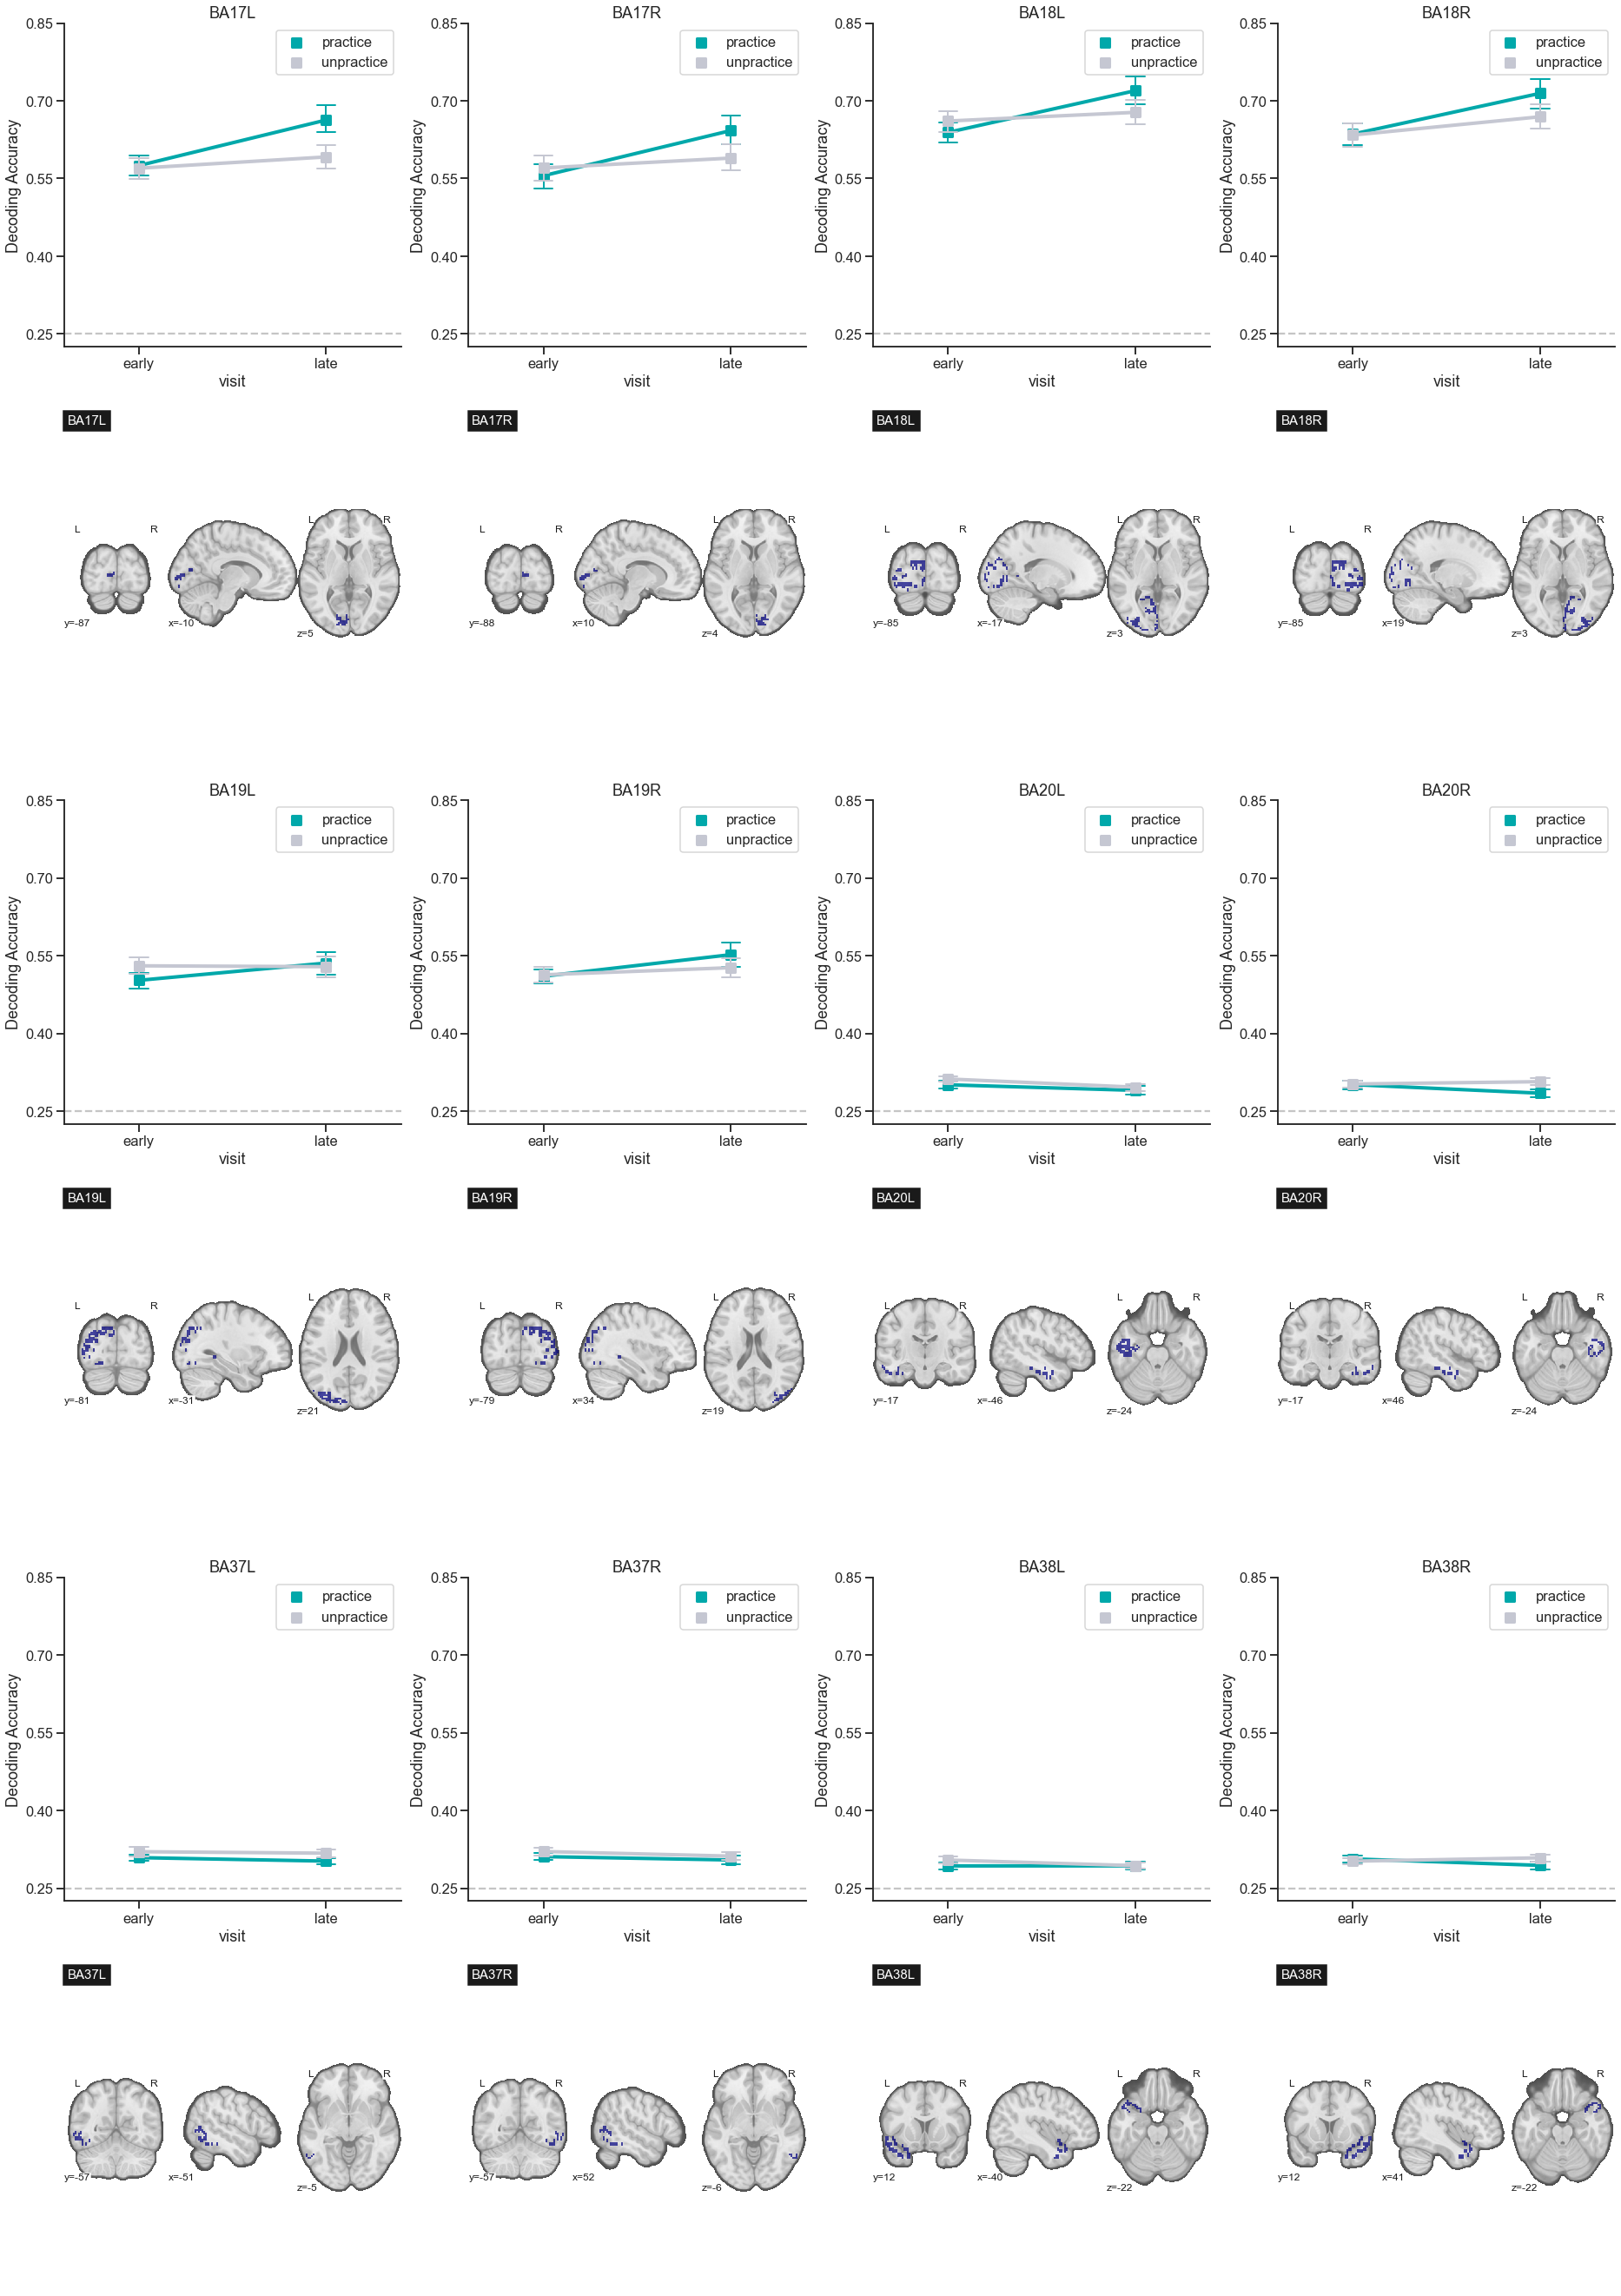

In [26]:
magn = 8   # a size of figures
ncol = 4   # a number of columns

nrow = 2*len(roi_imgs.keys())//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
for i, (name, img) in enumerate(roi_imgs.items()):
    print(name, end='\r')
    ax = draw_lineplot(wit_df, roi_name=name, title=name, ax=axes[i+(i//ncol)*ncol])
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=name
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i+(i//ncol)*ncol+ncol])

## *Whole-brain analysis with Fan280

In [20]:
with open(join(mask_dir,'fan280','fan280_fullname.csv'),'rb') as fb:
    fan_list = pd.read_csv(fb, header=None)

In [21]:
fan_imgs={}
path_list = glob(join(mask_dir,'fan280','*.nii.gz'))
for path in path_list:
    temp = path.split('/')[-1].replace('.nii.gz', '')
    fname = temp.split('.')[-1]
    fan_imgs[fname] = nilearn.image.load_img(path)

In [22]:
## LDA analysis
lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto', n_components=2)

In [23]:
nrun = 3
cv = GroupKFold(nrun)
y = np.array([j for i in range(nrun) for j in target_pos]) ## answer : [5, 25, 21, 1, 25,...]
group = np.array([i for i in range(nrun) for j in target_pos]) ## run number : [0, 0, ..., 1, 1, ..., 2, 2]

In [24]:
subj = '01'
stage = 'late_practice'
beta = load_betas(subj, stage)

In [25]:
X = fast_masking(img=beta[subj,stage], roi=roi_imgs['BA17L']) # (trial,voxel)
X_scaled = StandardScaler().fit_transform(X)
X_scaled.shape

(288, 157)

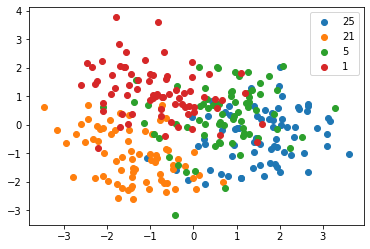

In [26]:
temp = lda.fit_transform(X_scaled, y)

for target in list(set(target_pos)):
    plt.scatter(temp[y==target,0], temp[y==target,1], label=target)
    plt.legend(loc='best', shadow=False, scatterpoints=1)

In [29]:
ypred = np.zeros(len(y))
scores = np.zeros(3)
for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
    Xtrain = X_scaled[idx_train]
    ytrain = y[idx_train]
    temp = lda.fit_transform(Xtrain, ytrain)
    
    Xtest = X_scaled[idx_test]
    ypred[idx_test] = lda.predict(Xtest)
    scores[i] = lda.score(Xtest,y[idx_test])

rval, pval = scipy.stats.pearsonr(y,ypred)
print(rval, pval, np.mean(scores))

0.24137062767365788 3.4768137129058844e-05 0.4791666666666667


### visual stream (Brodmann Area)

Accuracy = (TP+TN)/(TP+TN+FP+FN)\
Precision = TP/(TP+FP)\
Recall = TP/(TP+FN)

In [32]:
# df = pd.DataFrame(columns=['subj','stage','region','n_voxels','pval','rval','accuracy'])
df = pd.DataFrame(columns=['subj','stage','region','n_voxels','accuracy'])
for subj in subj_list:
    for stage in ['early_practice','late_practice']:
        beta = load_betas(subj, stage)
        for name, img in roi_imgs.items():
            X = fast_masking(img=beta[subj,stage], roi=img) # (trial,voxel)
            if X.shape[-1]<=3:
                continue
            X_scaled = StandardScaler().fit_transform(X)
            X_scaled.shape
#             ypred = np.zeros(len(y))
            scores = np.zeros(nrun)
            for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
                Xtrain = X_scaled[idx_train]
                ytrain = y[idx_train]
                temp = lda.fit_transform(Xtrain, ytrain)

                Xtest = X_scaled[idx_test]
#                 ypred[idx_test] = lda.predict(Xtest)
                
                scores[i] = lda.score(Xtest,y[idx_test])
#             rval, pval = scipy.stats.pearsonr(y,ypred)
            df = df.append(
                {'subj':subj
                 , 'stage':stage
                 , 'region':name
                 , 'n_voxels':X.shape[-1]
#                  , 'pval':pval, 'rval':rval
                 , 'accuracy':np.mean(scores)}
#                  , 'accuracy':sum(ypred==y)/len(y)
                , ignore_index=True)
df.to_csv(join(script_dir,today+'.lda.visual_stream.csv'),index=False)
df

,subj,stage,region,n_voxels,accuracy
0,01,early_practice,BA17L,157,0.750000
1,01,early_practice,BA17R,151,0.625000
2,01,early_practice,BA18L,724,0.795139
3,01,early_practice,BA18R,717,0.770833
4,01,early_practice,BA19L,761,0.555556
...,...,...,...,...,...
715,44,late_practice,BA20R,359,0.305556
716,44,late_practice,BA37L,308,0.312500
717,44,late_practice,BA37R,302,0.343750
718,44,late_practice,BA38L,304,0.298611


[(0.0, 0.8)]

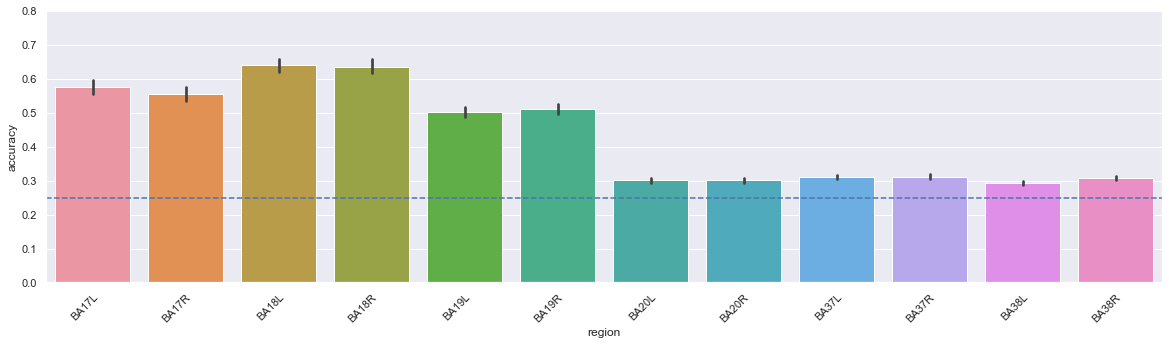

In [34]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.barplot(data=df[df.stage=='early_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

[(0.0, 0.8)]

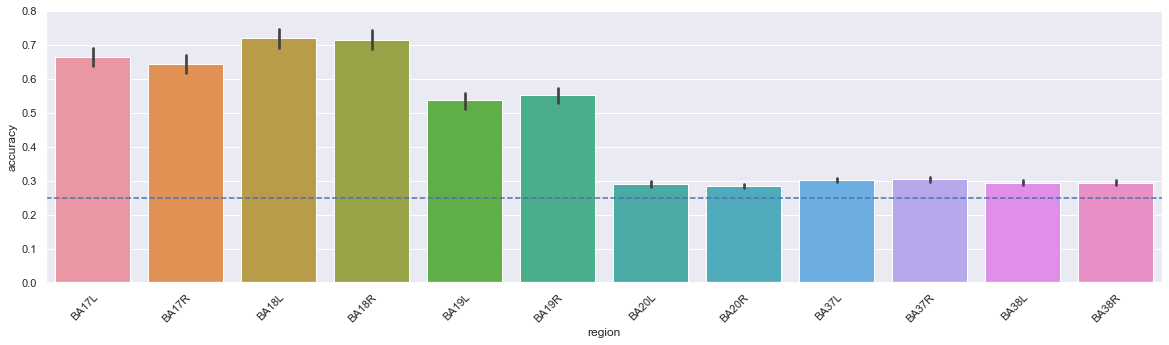

In [35]:
sns.set(rc={'figure.figsize':(20,5)})
ax = sns.barplot(data=df[df.stage=='late_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

### fan roi

In [36]:
df = pd.DataFrame(columns=['subj','stage','fan','region','n_voxels','accuracy'])
for subj in subj_list:
    for stage in ['early_practice','late_practice']:
        beta = load_betas(subj, stage)
        for num, img in fan_imgs.items():
            X = fast_masking(img=beta[subj,stage], roi=img) # (trial,voxel)
            if X.shape[-1]<=3:
                continue
            X_scaled = StandardScaler().fit_transform(X)
            X_scaled.shape
#             ypred = np.zeros(len(y))
            scores = np.zeros(nrun)
            for i, (idx_train, idx_test) in enumerate(cv.split(X, y, group)):
                Xtrain = X_scaled[idx_train]
                ytrain = y[idx_train]
                temp = lda.fit_transform(Xtrain, ytrain)

                Xtest = X_scaled[idx_test]
#                 ypred[idx_test] = lda.predict(Xtest)
                scores[i] = lda.score(Xtest,y[idx_test])
#             rval, pval = scipy.stats.pearsonr(y,ypred)
            df = df.append(
                {'subj':subj
                 , 'stage':stage
                 , 'fan':num
                 , 'region':fan_list.loc[int(num)-1,0]
                 , 'n_voxels':X.shape[-1]
#                  , 'pval':pval, 'rval':rval
                 , 'accuracy':np.mean(scores)}
                , ignore_index=True)
df.to_csv(join(script_dir,today+'.lda.fan280.csv'),index=False)
df

,subj,stage,fan,region,n_voxels,accuracy
0,01,early_practice,001,"Lt. superior frontal gyrus (BA8, medial)",286,0.298611
1,01,early_practice,002,"Rt. superior frontal gyrus (BA8, medial)",331,0.364583
2,01,early_practice,003,"Lt. superior frontal gyrus (BA8, dorsolateral)",359,0.291667
3,01,early_practice,004,"Rt. superior frontal gyrus (BA8, dorsolateral)",279,0.263889
4,01,early_practice,005,"Lt. superior frontal gyrus (BA9, lateral)",321,0.315972
...,...,...,...,...,...,...
16615,44,late_practice,274,Hypothalamus,116,0.260417
16616,44,late_practice,275,Brainstem,1189,0.263889
16617,44,late_practice,276,Periaqueductal gray,132,0.284722
16618,44,late_practice,277,Lt. substantia nigra,18,0.295139


In [17]:
# temp = glob(join(script_dir,'*.lda.fan280.csv'))
# temp

In [18]:
# df = pd.read_csv(temp[0])
# df

[(0.0, 0.8)]

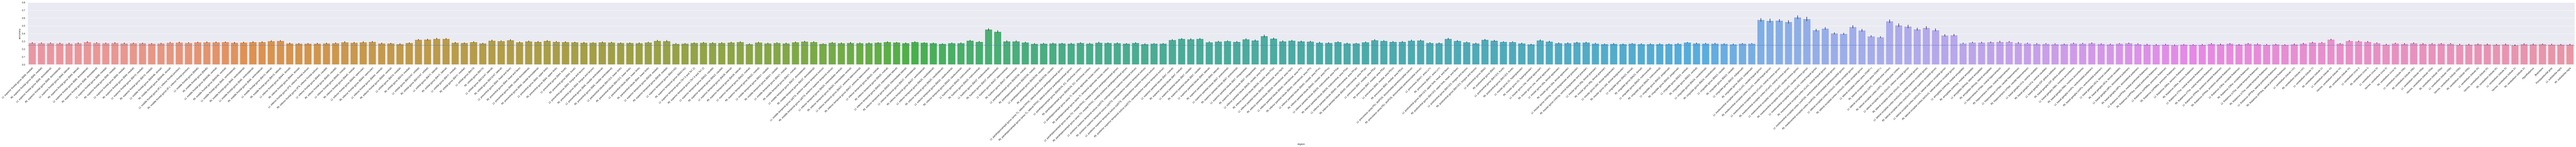

In [52]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=df[df.stage=='early_practice'], x='region', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

[(0.0, 0.8)]

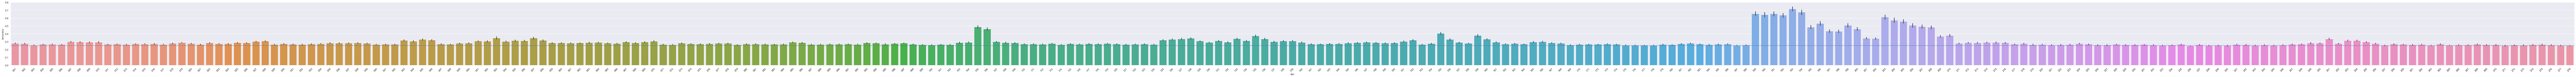

In [42]:
sns.set(rc={'figure.figsize':(200,5)})
ax = sns.barplot(data=df[df.stage=='late_practice'], x='fan', y='accuracy', ci=68)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right",rotation_mode='anchor')
ax.axhline(0.25, ls='--')
ax.set(ylim=(0, 0.8))

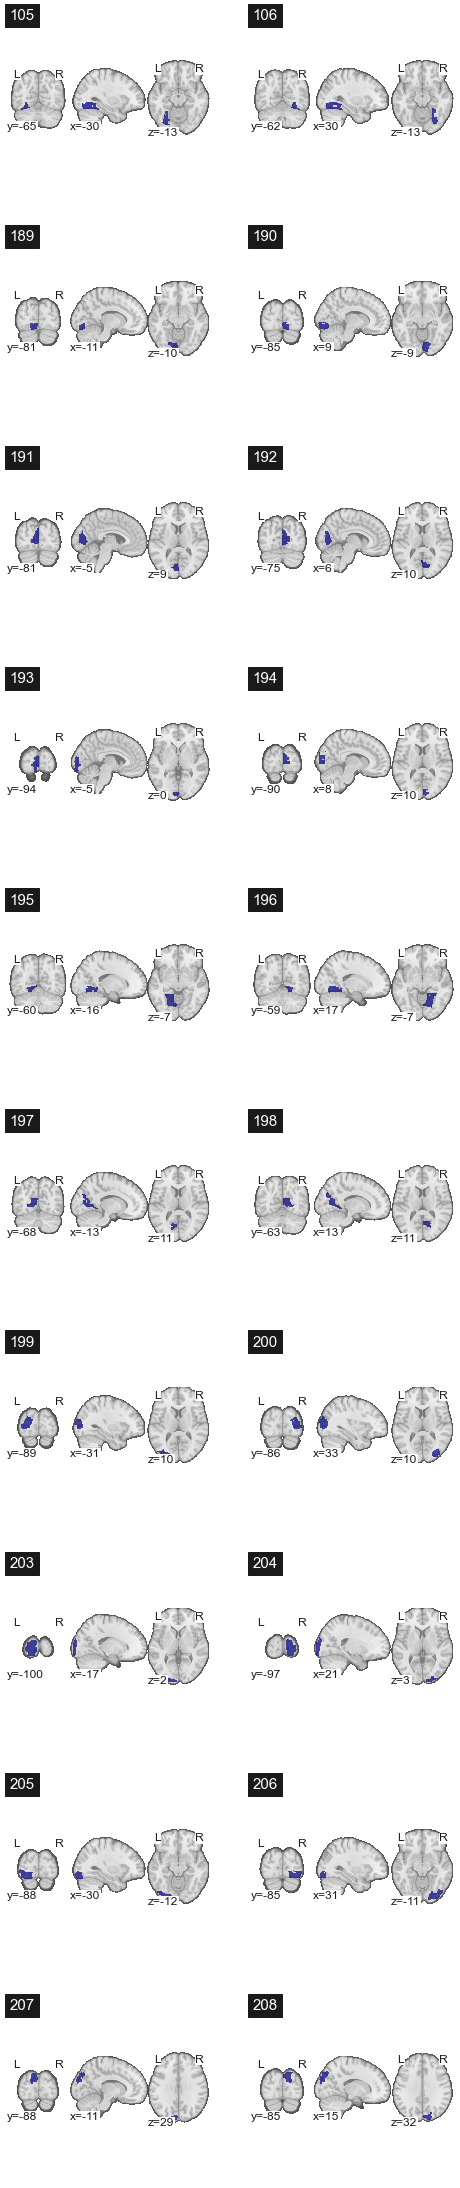

In [54]:
rois = ['105','106'
        ,'189','190','191','192','193','194','195','196','197','198','199','200'
        ,'203','204','205','206','207','208']

magn = 4   # a size of figures
ncol = 2   # a number of columns

nrow = len(rois)//ncol   # a number of rows
_, axes = plt.subplots(nrow,ncol,figsize=(ncol*magn,nrow*magn))
axes = np.concatenate(axes)
i = 0
for num, img in fan_imgs.items():
    if not num in rois:
        continue
    print(num, end='\r')
    nplt.plot_roi(roi_img=img, bg_img=img_bg, title=num
                  , draw_cross=False, black_bg=False
                  , display_mode='ortho', axes=axes[i])
    i += 1